# Figure out the magnitude limit of CPM method.

In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits
from tess_stars2px import tess_stars2px_function_entry
import eleanor
import tess_rotation as tr
import starspot as ss
import starry
from contextlib import contextmanager

import warnings
warnings.filterwarnings('ignore')

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

Define functions for injection and recovery.

In [2]:
# Calculate counts for a star of a certain magnitude
def mag_to_counts(mag, seconds):
    """
    Convert stellar magnitude to electron counts.
    
    "15,000 e−/s for a star of m = 10: thus, a star of m = 5 will create 3 × 106 electrons in a two-second exposure"
    10 x fainter is a magnitude increase of 2.5 
    
    F2/F1 approx 2.5^(delta m)
    delta m = 1
    F2/F1 = 2.5
    
    delta m = log(F2/F1)/log(2.5)
    for F2/F1 = 10, delta m = 2.5
    
    For a change of 1 mag, the change in brightness is 2.5.
    For a change of 2.5 mag, the change in brightness is 10.
    For a change of 5 mag, the change in brightness is 100.
    """
    m = 10
    e = 15000
    delta_m = m - mag
    factor = 2.51**delta_m
    counts_per_sec = e * factor
    return counts_per_sec * seconds


# Inject a sinusoidal signal into each sector.
def inject_signal(ticid, period, amplitude, baseline, tesscut_path,
                  lower_sector_limit=0, upper_sector_limit=14, xpix=68, ypix=68):
    
    sectors, star = tr.get_sectors(ticid, lower_sector_limit=lower_sector_limit,
                                   upper_sector_limit=upper_sector_limit)

    # Eleanor object
    print("Finding Eleanor object...")
    for sector in sectors:
        print("sector", sector)

        print(ticid, sector)
        star = eleanor.Source(tic=ticid, sector=int(sector), tc=True)
        sec, camera, ccd, colrowpix = star.sector, star.camera, star.chip, star.position_on_chip
        ra, dec = star.coords
        
        fits_file = tr.get_fits_filenames(tesscut_path, sector, camera, ccd, ra, dec)
        
        path_to_tesscut = "{0}/astrocut_{1:12}_{2:13}_{3}x{4}px".format(tesscut_path, ra, dec, xpix, ypix)
        inj_dir = "{0}/injected".format(path_to_tesscut)
        if not os.path.exists(inj_dir):
            os.mkdir(inj_dir)
        injection_filename = \
        "{0}/tess-s{1}-{2}-{3}_{4:.6f}_{5:.6f}_{6}x{7}_astrocut.fits".format(
            inj_dir, str(int(sector)).zfill(4), camera, ccd, ra, dec, xpix, ypix)

        tr.inject_one_sector(ticid, sector, period, amplitude, baseline, sec,
                             camera, ccd, colrowpix, fits_file, injection_filename)
        

# Create CPM light curve from all sectors
def CPM_recover(ticid, tesscut_path, lower_sector_limit=0,
                upper_sector_limit=1000):

    print("Searching for observed sectors...")
    sectors, star = tr.get_sectors(ticid,
                                   lower_sector_limit=lower_sector_limit,
                                   upper_sector_limit=upper_sector_limit)
    print("sectors found: ", sectors)

    print("Creating light curve..")
    xs, ys = [], []
    for sector in sectors:
        print("sector", sector)
        star = eleanor.Source(tic=ticid, sector=int(sector), tc=True)
        x, y = CPM_one_sector(ticid, tesscut_path, sector, star.camera,
                              star.chip, star.coords[0], star.coords[1])
        xs.append(x)
        ys.append(y)

    return xs, ys, sectors


# Create CPM light curve for one sector.
def CPM_one_sector(ticid, tesscut_path, sector, camera, ccd, ra, dec, xpix=68, ypix=68):
    fits_file = tr.get_fits_filenames(tesscut_path, sector, camera, ccd, ra, dec,
                                      xpix=xpix, ypix=ypix)    
    path_to_tesscut = "{0}/astrocut_{1:12}_{2:13}_{3}x{4}px".format(tesscut_path, ra, dec, xpix, ypix)
    inj_dir = "{0}/injected".format(path_to_tesscut)
    injected_filename = "{0}/tess-s{1}-{2}-{3}_{4:.6f}_{5:.6f}_{6}x{7}_astrocut.fits".format(
        inj_dir, str(int(sector)).zfill(4), camera, ccd, ra, dec, xpix, ypix)

    # Create CPM light curve
    x, y = tr.make_lc_single_sector(sector, [33, 35], [33, 35], injected_filename,
                                    plot=False, save_to_file=False)
    return x, y

Download TESS cutouts.

In [3]:
ticid = 765143490
with suppress_stdout():
    sectors, _ = tr.get_sectors(ticid, upper_sector_limit=14)
print(sectors)

[ 1  2  4  5  6  7  8  9 10 11 12]


In [4]:
# with suppress_stdout():
#     tr.download_tess_cuts(ticid, lower_sector_limit=0, upper_sector_limit=14)

Inject into raw pixel data.

In [5]:
tesscut_path = "/Users/rangus/projects/TESS-rotation/data/TESScut/"
    
baseline = mag_to_counts(15, 2)
period, amplitude = 50, 3

#------Reproducing inject_signal function:-------------------

# sectors, star = tr.get_sectors(ticid, upper_sector_limit=14)

# # Eleanor object
# print("Finding Eleanor object...")
# time = []
# for sector in sectors:
#     print("sector", sector)

#     star = eleanor.Source(tic=ticid, sector=int(sector), tc=True)
#     sec, camera, ccd = star.sector, star.camera, star.chip
#     colrowpix = star.position_on_chip
#     ra, dec = star.coords

#     fits_image_filename = tr.get_fits_filenames(tesscut_path, sec, camera,
#                                                 ccd, star.coords[0],
#                                                 star.coords[1])
#     path_to_tesscut = "{0}/astrocut_{1:12}_{2:13}_{3}x{4}px".format(
#         tesscut_path, ra, dec, 68, 68)
#     inj_dir = "{0}/injected".format(path_to_tesscut)
#     injection_filename = "{0}/tess-s{1}-{2}-{3}_{4:.6f}_{5:.6f}_{6}x{7}_astrocut.fits".format(
#         inj_dir, str(int(sector)).zfill(4), camera, ccd, ra, dec, 68, 68)

#     # Load the TESScut FFI data (get time array)
#     hdul = fits.open(fits_image_filename)
#     postcard = hdul[1].data
#     t = postcard["TIME"]*1.
#     flux = postcard["FLUX"]*1.
#     print("time len", len(t))

#     time.append(t)

# # Create the multi-sector signal
# time_array = np.array([i for j in time for i in j])
# signal = baseline + tr.get_random_light_curve(time_array, period, amplitude)

In [6]:
# def inject_one_sector_starry(ticid, sector, signal, camera, ccd,
#                              colrowpix, fits_image_filename,
#                              injection_filename, offset_x=0., offset_y=0.):

#     # Load the TESScut FFI data
#     print("Loading TESScut FFI...")
#     hdul = fits.open(fits_image_filename)
#     postcard = hdul[1].data
#     time = postcard["TIME"]*1.
#     flux = postcard["FLUX"]*1.
#     print(len(time))

#     # Get the PRF
#     print("Fetching PRF...")
#     path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/"
#     prf = tr.getPrfAtColRowFits(colrowpix[0], colrowpix[1], ccd, camera, sector,
#                              path)  # col, row, ccd, camera, sector

#     # Inject the signal and save the new file.
#     print("Injecting signal and saving...")
#     injected_flux = flux + signal[:, None, None] * tr.move_prf(
#         prf, offset_x, offset_y, npix=68)[None, :, :]
#     hdul[1].data["FLUX"] = injected_flux
#     if os.path.exists(injection_filename):
#         os.remove(injection_filename)
#     hdul.writeto(injection_filename)
#     hdul.close()
#     return time, signal

# for i, sector in enumerate(sectors):
    
#     star = eleanor.Source(tic=ticid, sector=int(sector), tc=True)
#     sec, camera, ccd = star.sector, star.camera, star.chip
#     colrowpix = star.position_on_chip
#     ra, dec = star.coords

#     fits_image_filename = tr.get_fits_filenames(tesscut_path, sec, camera,
#                                              ccd, star.coords[0],
#                                              star.coords[1])
#     path_to_tesscut = "{0}/astrocut_{1:12}_{2:13}_{3}x{4}px".format(
#         tesscut_path, ra, dec, 68, 68)
#     inj_dir = "{0}/injected".format(path_to_tesscut)
#     injection_filename = "{0}/tess-s{1}-{2}-{3}_{4:.6f}_{5:.6f}_{6}x{7}_astrocut.fits".format(
#         inj_dir, str(int(sector)).zfill(4), camera, ccd, star.coords[0], star.coords[1], 68, 68)

#     mask = (time[i][0] <= time_array) & (time_array <= time[i][-1])
#     print(len(signal[mask]), len(time[i]))
#     assert len(signal[mask]) == len(time[i])
#     inject_one_sector_starry(ticid, sector, signal[mask], camera, ccd,
#                                 colrowpix, fits_image_filename,
#                                 injection_filename)

In [7]:
with suppress_stdout():
    itime, isignal = tr.inject_signal(ticid, period, amplitude, baseline, tesscut_path, 14)

INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_bkg.fits with expected size 79384320. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc.fits with expected size 158880960. [astroquery.query]
INFO: Found cached file /Users/rangus/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0012-4-2-cal-1784-1240_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0012-4-2_tess_v2_pm.txt with expected size 239290. [astroquery.query]
Finding Eleanor object...
sector 1
sector 2
sector 4
sector 5
sector 6
sector 7
sector 8
sector 9
sector 10
sector 11
sector 12


Pre-computing some matrices... Done.
Compiling `flux`... Done.


sector 1
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 2
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 4
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 5
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 6
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 7
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 8
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 9
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 10
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 11
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 12
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...


Recover CPM light curve.

In [8]:
with suppress_stdout():
    time_cpm, flux_cpm, sectors = CPM_recover(ticid, tesscut_path, lower_sector_limit=0, upper_sector_limit=14)

Stitch light curve.

In [9]:
time, flux, flux_err = tr.stitch_light_curve(ticid, time_cpm, flux_cpm)

Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
104it [00:00, 154.40it/s, logp=4.239579e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 523.6796488196894 -> 4239.579454463883


Measure period

In [10]:
p = np.polyfit(time, flux, 1)
rotate = ss.RotationModel(time, flux-np.polyval(p, time), flux_err)
ls_period = rotate.ls_rotation(max_period=200.)
print(ls_period)

49.647006255585346


In [14]:
print(np.shape(time), np.shape(flux), np.shape(itime), np.shape(isignal))

(12275,) (12275,) (12739,) (12739,)


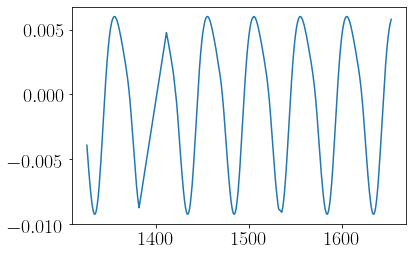

In [16]:
med = np.median(isignal)
plt.plot(itime, isignal/med - 1)

Plot light curve.

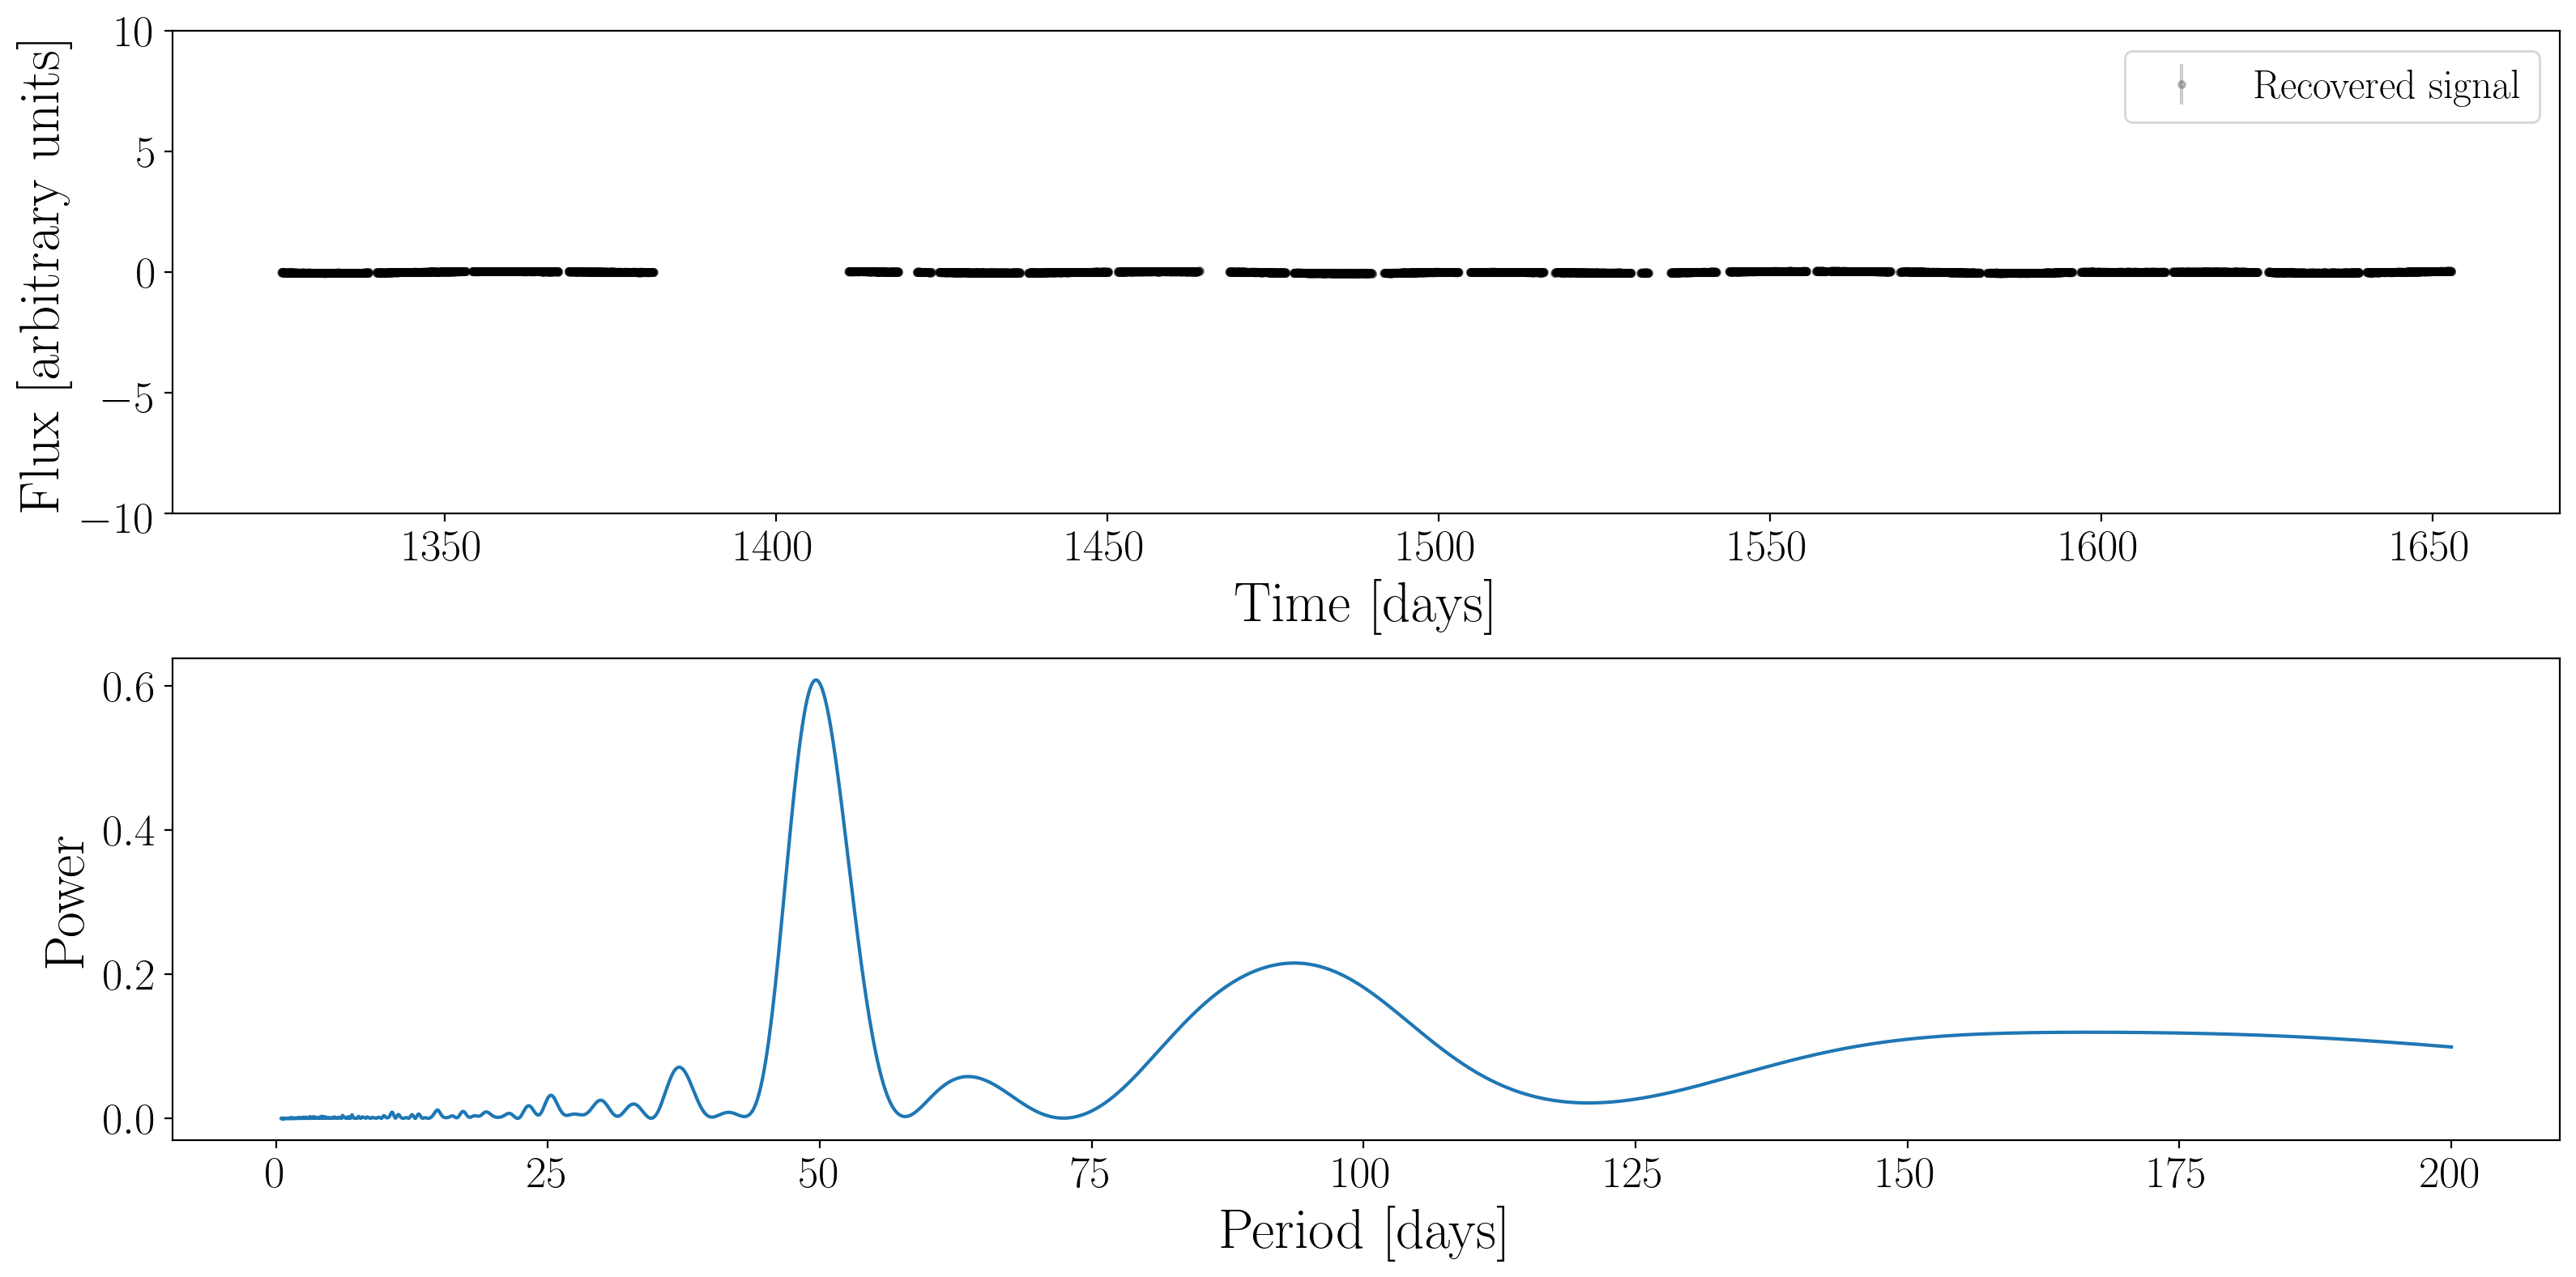

In [12]:
fig = plt.figure(figsize=(16, 8), dpi=200)
ax1 = fig.add_subplot(211)
xs = np.linspace(min(time), max(time), 1000)
ax1.errorbar(time, flux-np.polyval(p, time), yerr=flux_err, fmt="k.", alpha=.2, label="$\mathrm{Recovered~signal}$", rasterized=True)
# ax1.plot(xs, 0.05*np.sin(xs*2*np.pi/50), "C1", zorder=10, label="$\mathrm{Injected~signal}$")
for i in range(len(itime)):
    ax1.plot(itime[i], isignal[i], "C1")
ax1.legend(fontsize=18)
ax1.set_xlabel("$\mathrm{Time~[days]}$")
ax1.set_ylabel("$\mathrm{Flux~[arbitrary~units]}$");
ax1.set_ylim(-10,  10)

ax2 = fig.add_subplot(212)
ax2.plot(1./rotate.freq, rotate.power)
ax2.set_xlabel("$\mathrm{Period~[days]}$")
ax2.set_ylabel("$\mathrm{Power}$");

plt.tight_layout()